In [58]:
import numpy as np
import pandas as pd
import scipy
import sklearn

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error

from itertools import product

from sklearn.cluster import KMeans

import lightgbm as lgb

from xgboost import XGBRegressor
from xgboost import plot_importance

import matplotlib.pyplot as plt
%matplotlib inline

d:\ncku\AI_env\.venv\lib\site-packages\pkg_resources\__init__.py:119: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [2]:
# Basic data loading

df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv', index_col='ID')

df_shops = pd.read_csv('shops.csv', index_col='shop_id')

df_items = pd.read_csv('items.csv', index_col='item_id')
df_itemcat = pd.read_csv('item_categories.csv', index_col='item_category_id')

sample_submission = pd.read_csv('sample_submission.csv', index_col='ID')

In [3]:
# Calendar

calendar = pd.read_csv('calendar.csv', dtype='int16')

In [4]:
# Shops

def shop_name2city(sn):
    sn = sn.split()[0]
    if sn == 'Цифровой' or sn == 'Интернет-магазин': sn = 'Internet'
    if sn[0] == '!': sn = sn[1:]  
    return sn

df_shops['city'] = df_shops['shop_name'].apply(shop_name2city)
df_shops['city_enc'] = LabelEncoder().fit_transform(df_shops['city']).astype('int8')

city_info = pd.read_pickle('city_info.pkl')

df_shops['city_size'] = df_shops['city'].map(city_info['city_size'])

In [5]:
# Define items class

class Items():

    def __init__(self, df_items, df_itemcat):
        
        self.df_items    = df_items
        self.df_itemcat  = df_itemcat
        
        self.set_hl_cat()
        self.make_items_ext()
        
        self.item_features = ['item_category_id', 'hl_cat_id']

    def set_hl_cat(self):
        
        self.df_itemcat['hl_cat_id'] = self.df_itemcat['item_category_name'].str.split(n=1, expand=True)[0]
        self.df_itemcat['hl_cat_id'] = LabelEncoder().fit_transform(self.df_itemcat['hl_cat_id'])
        
    def make_items_ext(self):
    
        self.df_items = df_items.merge(self.df_itemcat, how = 'left', 
                                       left_on = 'item_category_id', right_index = True)

    def get_items_df(self):
        
        return self.df_items[self.item_features].astype('int32')

In [6]:
items = Items(df_items, df_itemcat)

In [7]:
# Define train-test class

class TT_Extended():
    
    def __init__(self, df_train, df_test, items, df_shops, calendar, cmode, verbose=True):
        
        self.info = verbose
        
        self.df_train  = df_train.copy()
        self.df_test   = df_test.copy()
        self.df_shops  = df_shops.copy()
        self.calendar  = self.set_calender(calendar.copy())
        
        self.idx_columns = ['date_block_num', 'shop_id', 'item_id']
        
        self.df_test['date_block_num'] = 34
        self.df_test['item_cnt_month'] = 0.
        self.df_test['item_cnt_month'] = self.df_test['item_cnt_month'].astype('float32')
        
        self.df_train[self.idx_columns] = self.df_train[self.idx_columns].astype('int32')
        self.df_test[self.idx_columns]  = self.df_test[self.idx_columns].astype('int32')
        
        self.df_train_cleaning(cmode)
        
        self.item_mean_features = []
        self.shop_mean_features = []
        self.lag_names_to_clip  = []
        
        self.df_items = items.get_items_df()
        self.item_ext_features = list(self.df_items.columns)
        self.df_items_ext = self.items_ext()
        
        self.df_bb = self.build_bb()
        
        # Critical point: 0 or None
        self.df_train_ext = self.df_train_agg(cmin = 0, cmax = 1000, drop = None)
        
        self.add_test_df()
        
        self.df_train_ext = self.df_train_extention()
        
    def df_train_cleaning(self, mode):
        
        assert mode in ['keep', 'drop', 'block', 'total', 't+b']
        
        # 'keep'  - do nothing
        # 'drop'  - drop all negative rows
        # 'block' - remove item_id if its sum is negative in a block
        # 'total' - remove item_id if its total sum is negative
        # 't+b'   - 'total' + 'block'
        
        if self.info: print('Cleaning train dataframe... ( Mode -', mode, ')')
         
        # Remove very noisy shops 
        
        shop_idx = self.df_train[(self.df_train['shop_id'] == 9)  | 
                                 (self.df_train['shop_id'] == 20)].index
        self.df_train.drop(shop_idx, inplace=True)
        
        
        self.df_train = self.df_train[(self.df_train['item_price'] > 0) & 
                                      (self.df_train['item_price'] < 51000)]
        self.df_train = self.df_train[self.df_train['item_cnt_day'] <= 1000]

        shop_repl_dict = {0 : 57, 1 : 58, 11 : 10, 40 : 39}
    
        self.df_train['shop_id'] = self.df_train['shop_id'].apply(
                                   lambda s: shop_repl_dict.get(s) if s in shop_repl_dict else s)    
            
            
        if   mode == 'drop':
            self.df_train = self.df_train[self.df_train['item_cnt_day'] > 0]
            
        elif mode == 'block':
            item_block_cnt = self.df_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_block_cnt[item_block_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['date_block_num', 'shop_id', 'item_id']).index.isin(items_to_drop)]
        elif mode == 'total':
            item_total_cnt = self.df_train.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_total_cnt[item_total_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['shop_id', 'item_id']).index.isin(items_to_drop)]
            
        elif mode == 't+b':
            item_total_cnt = self.df_train.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_total_cnt[item_total_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['shop_id', 'item_id']).index.isin(items_to_drop)]
            
            item_block_cnt = self.df_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_block_cnt[item_block_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['date_block_num', 'shop_id', 'item_id']).index.isin(items_to_drop)]
            
            
        return
        
    def set_calender(self, calendar):
        
        calendar['date_block_num'] = (calendar['year'] - 2013)*12 + (calendar['month'] - 1)
        calendar['hdays'] = calendar['mdays'] - calendar['wdays']
        calendar.set_index('date_block_num', inplace=True)
        
        return calendar
    
    def items_ext(self):
        
        dfi = self.df_items.copy()
        
        dfi['fsb'] = self.df_train.groupby('item_id')['date_block_num'].min()
        
        dfi['fsb'].fillna(34, inplace=True)
        dfi['fsb'] = dfi['fsb'].astype('int8')
        
        self.item_ext_features += ['fsb']
        
        return dfi
    
    def build_bb(self):
        
        if self.info: print('Building index dataframe...')

        df_work = []

        for block_num in self.df_train['date_block_num'].unique():
    
            cur_shops = self.df_train.loc[self.df_train['date_block_num'] == block_num, 'shop_id'].unique()
            cur_items = self.df_train.loc[self.df_train['date_block_num'] == block_num, 'item_id'].unique()
    
            df_work.append(np.array(list(product(*[[block_num], cur_shops, cur_items])), dtype='int32'))

        df_work = pd.DataFrame(np.vstack(df_work), columns = self.idx_columns)
            
        return df_work
    
    def df_train_agg(self, cmin = 0, cmax = 20, drop = None):
        
        if self.info: print('Aggregation...')
        
        df_work = self.df_train.groupby(self.idx_columns).agg({'item_price'  : np.mean, 
                                                               'item_cnt_day': np.sum})
        df_work.reset_index(inplace=True)
        df_work = df_work.rename(columns={'item_cnt_day': 'item_cnt_month'})
        
        df_work = pd.merge(self.df_bb, df_work, on=self.idx_columns, how='left')
        
        df_work['item_cnt_month'] = df_work['item_cnt_month'].astype('float32').fillna(0.).clip(cmin, cmax)
        df_work['item_price'] = df_work['item_price'].astype('float32').fillna(0.)
        
        df_tmp = self.df_train[self.df_train['item_cnt_day'] > 0].groupby(self.idx_columns).agg({'item_cnt_day': 'count'})
        df_tmp.reset_index(inplace=True)
        df_tmp = df_tmp.rename(columns={'item_cnt_day': 'item_rate_month'})
        
        df_work = pd.merge(df_work, df_tmp, on=self.idx_columns, how='left')
        
        df_work['item_rate_month'] = df_work['item_rate_month'].astype('float32').fillna(0.)
        
        del df_tmp
        
        if drop: df_work.drop(drop, axis=1, inplace=True)
        
        return df_work
    
    def add_test_df(self):
        
        self.df_train_ext = pd.concat([self.df_train_ext, self.df_test], ignore_index=True,
                                      sort=False, keys=self.idx_columns)
    
    def add_item_means(self, df, feature = None):
        
        # Adding item means
        
        if feature == None :
            group_items = ['date_block_num','item_id']
            feature = 'item_cnt'
        else:
            group_items = ['date_block_num','item_id'] + [feature]
            
        feature_mean_name = feature + '_mean'
            
        if self.info: print('Adding item means for', feature, '...')
        
        df_tmp = df.groupby(group_items)['item_cnt_month'].mean()
        df_tmp = df_tmp.reset_index().rename(columns = {'item_cnt_month': feature_mean_name})
        
        df = pd.merge(df, df_tmp, on=group_items, how='left')
        
        self.item_mean_features.append(feature_mean_name)
        
        del df_tmp
        
        return df
    
    def add_shop_means(self, df, feature):
        
        # Adding shop means
        
        group_items = ['date_block_num', 'shop_id'] + [feature]
            
        feature_mean_name = feature + '_mean'
            
        if self.info: print('Adding shop means for', feature, '...')
        
        df_tmp = df.groupby(group_items)['item_cnt_month'].mean()
        df_tmp = df_tmp.reset_index().rename(columns = {'item_cnt_month': feature_mean_name})
        
        df = pd.merge(df, df_tmp, on=group_items, how='left')
        
        self.shop_mean_features.append(feature)
        
        del df_tmp
        
        return df
        
    
    def df_train_extention(self, test_cat_only = False):
        
        df_work = self.df_train_ext.merge(df_shops[['city_enc', 'city_size']], how = 'left', on = 'shop_id')
        
        df_work = df_work.merge(self.calendar[['mdays', 'wdays', 'hdays']], 
                                how = 'left', left_on = 'date_block_num', right_index = True)
        
        df_work = df_work.merge(self.df_items_ext[self.item_ext_features],
                                how = 'left', left_on = 'item_id', right_index = True)
        
        # Shop start block number
        
        ssbn = self.df_train.groupby('shop_id')['date_block_num'].min().astype('int8')
        ssbn.name = 'ssbn'
        df_work = df_work.merge(ssbn, how = 'left', on = 'shop_id')
        
        if test_cat_only:
            test_cat = df_work[df_work['date_block_num'] == 34]['item_category_id'].unique()
            df_work = df_work[df_work['item_category_id'].isin(test_cat)]

        return df_work
    
    def make_base_df(self, keepnans = False):
        
        # Make base dataframe
        
        df_work = self.df_train_ext.copy()
        
        if keepnans:
            fill_value = None
        else:
            fill_value = 0    
            
        df_work = pd.pivot_table(df_work, values='item_cnt_month', index=['shop_id', 'item_id'], 
                                     columns = 'date_block_num', aggfunc=np.sum, fill_value = fill_value)
        df_work.columns.name = ''
        
        return df_work
    
    def add_total_cnt(self, df):
        
        if self.info: print('Adding total count...')
        
        df_base = self.make_base_df()
        
        for i in range(1, 33):
            df_base[i + 1] += df_base[i]
            
        df_base = df_base.shift(1, axis=1).loc[:, 1:].astype('int32')
        df_base = df_base.melt(var_name='date_block_num', value_name='total_cnt', ignore_index=False)
        
        df = df.merge(df_base, how='left', on=self.idx_columns)
        
        del df_base
        
        return df
    
    def add_item_lags(self, df, feature_name, nlags=3, keepnans=False, dnc=False):
        
        if self.info: print('Adding item lags for', feature_name, '...')
    
        df_tmp = df[['date_block_num', 'shop_id', 'item_id', feature_name]]
    
        for i in range(nlags, 0, -1):
        
            lag_feature_name = feature_name +'_lag-' + str(i)
            if not dnc: self.lag_names_to_clip.append(lag_feature_name)
        
            df_shifted = df_tmp.copy()
            df_shifted.columns = ['date_block_num', 'shop_id', 'item_id', lag_feature_name]
            df_shifted['date_block_num'] += i
            df = pd.merge(df, df_shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
            
            if keepnans:
                df[lag_feature_name] = df[lag_feature_name].astype('float32')
            else:
                df[lag_feature_name] = df[lag_feature_name].fillna(0).astype('float32')
        
        del df_tmp
    
        return df
    
    def add_shop_lags(self, df, feature_name, nlags=3, dnc=False):
        
        mean_feature_name = feature_name + '_mean'
        
        if self.info: print('Adding lags for', mean_feature_name, '...')
    
        df_tmp = df[['date_block_num', 'shop_id', feature_name, mean_feature_name]]
    
        for i in range(nlags, 0, -1):
        
            lag_feature_name = mean_feature_name + '_lag-' + str(i)
            if not dnc: self.lag_names_to_clip.append(lag_feature_name)
        
            df_shifted = df_tmp.copy()
            df_shifted.columns = ['date_block_num', 'shop_id', feature_name, lag_feature_name]
            df_shifted['date_block_num'] += i
            df = pd.merge(df, df_shifted.drop_duplicates(), on=['date_block_num', 'shop_id', feature_name], how='left')
            df[lag_feature_name] = df[lag_feature_name].fillna(0).astype('float32')
        
        del df_tmp
        del df_shifted
    
        return df
    
    def shop_clustering(self, df_work):
        
        # Clustering algorithm can be defined at run time
        
        print('No shop clusters provided')
        
        return df_work
    
    def build_work_db(self, hd, item_mean_features = [], shop_mean_features = [], add_total_cnt = False):
        
        if self.info: print('Building work dataframe...')
        
        df_work = self.df_train_ext.copy()
        
        df_work = self.add_item_means(df_work)
        
        for mf in item_mean_features:
            
            df_work = self.add_item_means(df_work, mf)
            
        for mf in shop_mean_features:
            
            df_work = self.add_shop_means(df_work, mf)
        
        # Critical point: True or False (Affects qmean calculation)
        df_work = self.add_item_lags(df_work, 'item_cnt_month', hd, keepnans=False)
        df_work = self.add_item_lags(df_work, 'item_rate_month', hd, dnc=True)
        df_work = self.add_item_lags(df_work, 'item_price', hd, dnc=True)
            
        for mf in self.item_mean_features:
            
            df_work = self.add_item_lags(df_work, mf, hd)
            
        for mf in self.shop_mean_features:
            
            df_work = self.add_shop_lags(df_work, mf, hd)
        
        df_work.drop(df_work[df_work['date_block_num'] < hd].index, inplace=True)
        
        df_work.drop(self.item_mean_features, axis=1, inplace=True)
        df_work.drop(['item_category_id_mean', 'item_price', 'item_rate_month'], axis=1, inplace=True)
        
        self.item_mean_features = []
        self.shop_mean_features = []
        
    
        df_work['qmean'] = df_work[['item_cnt_month_lag-1', 
                                    'item_cnt_month_lag-2', 
                                    'item_cnt_month_lag-3']].mean(skipna=True, axis=1)
        
        df_work['new'] = df_work['fsb'] ==  df_work['date_block_num']
        
        df_work['fsb'] = df_work['date_block_num'] - df_work['fsb']
        df_work['ssbn'] = df_work['date_block_num'] - df_work['ssbn']
        
        df_work['month'] = (df_work['date_block_num']%12).astype('int8')
        
        
        idx = df_work[(df_work['item_price_lag-1'] == 0) & (df_work['item_price_lag-2'] != 0)].index
        df_work.loc[idx, 'item_price_lag-1'] = df_work.loc[idx, 'item_price_lag-2']
        idx = df_work[(df_work['item_price_lag-2'] == 0) & (df_work['item_price_lag-3'] != 0)].index
        df_work.loc[idx, 'item_price_lag-2'] = df_work.loc[idx, 'item_price_lag-3']
        
        df_work['grad-1'] = df_work['item_cnt_month_lag-1']/df_work['item_cnt_month_lag-2']
        df_work['grad-1'] = df_work['grad-1'].replace([np.inf, -np.inf], np.nan).fillna(0.)

        df_work['grad-2'] = df_work['item_cnt_month_lag-2']/df_work['item_cnt_month_lag-3']
        df_work['grad-2'] = df_work['grad-2'].replace([np.inf, -np.inf], np.nan).fillna(0.)
        
        # Shop clustering
        
        df_work = self.shop_clustering(df_work)
        
        # Moving total
        
        if add_total_cnt: df_work = self.add_total_cnt(df_work)
            
        # Clipping    
  
        col2clip = ['item_cnt_month', 'qmean'] + self.lag_names_to_clip
        df_work[col2clip] = df_work[col2clip].clip(0, 20)
        
        return df_work
    
    def get_work_db(self, hd = 3, item_mean_features = [], 
                                  shop_mean_features = [], 
                                  drop_features = None,
                                  add_total_cnt = False):
        
        df_work = self.build_work_db(hd, item_mean_features, shop_mean_features, add_total_cnt)

        if drop_features == None:
            return df_work
        else:
            return df_work.drop(drop_features, axis = 1)

In [8]:
%%time

pfs = TT_Extended(df_train, df_test, items, df_shops, calendar, cmode='total')

Cleaning train dataframe... ( Mode - total )
Building index dataframe...
Aggregation...
Wall time: 24.2 s


In [9]:
pfs.df_train_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10987637 entries, 0 to 10987636
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int32  
 1   shop_id           int32  
 2   item_id           int32  
 3   item_price        float32
 4   item_cnt_month    float32
 5   item_rate_month   float32
 6   city_enc          int8   
 7   city_size         float32
 8   mdays             int16  
 9   wdays             int16  
 10  hdays             int16  
 11  item_category_id  int32  
 12  hl_cat_id         int32  
 13  fsb               int8   
 14  ssbn              int8   
dtypes: float32(4), int16(3), int32(5), int8(3)
memory usage: 555.4 MB


In [10]:
# Define shop clustering methods

def simple_shop_clustering(df_work):
    
    noisy_shops = [25, 31, 42]
    df_work['shop_group'] = df_work['shop_id'].isin(noisy_shops)
    
    return df_work

def knn_shop_clustering(df_work):
    
    df_sg = pd.pivot_table(df_work[df_work['item_cnt_month'] != 0], 
                           values='item_cnt_month', index=['shop_id'], 
                           columns = 'date_block_num', aggfunc='count', fill_value = 0)
    
    kmeans = KMeans(n_clusters=6, random_state=0).fit(df_sg)
    df_sg['shop_group'] = kmeans.labels_.astype('int8')
    df_work['shop_group'] = df_work['shop_id'].map(df_sg['shop_group'])
    
    del df_sg
    
    assert list(df_work[df_work['shop_group'].isna()]['shop_id'].unique()) == [], 'Missing shop found'
    
    return df_work

In [11]:
pfs.shop_clustering = simple_shop_clustering

In [12]:
%%time

df_work = pfs.get_work_db(hd = 3, 
                          item_mean_features = ['city_enc'], 
                          shop_mean_features = ['item_category_id'], 
                          drop_features = ['wdays', 'hdays', 'ssbn'],
                          add_total_cnt = False).copy()

Building work dataframe...
Adding item means for item_cnt ...
Adding item means for city_enc ...
Adding shop means for item_category_id ...
Adding item lags for item_cnt_month ...
Adding item lags for item_rate_month ...
Adding item lags for item_price ...
Adding item lags for item_cnt_mean ...
Adding item lags for city_enc_mean ...
Adding lags for item_category_id_mean ...
Wall time: 2min 2s


In [13]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9866074 entries, 1121563 to 10987636
Data columns (total 34 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int32  
 1   shop_id                      int32  
 2   item_id                      int32  
 3   item_cnt_month               float32
 4   city_enc                     int8   
 5   city_size                    float32
 6   mdays                        int16  
 7   item_category_id             int32  
 8   hl_cat_id                    int32  
 9   fsb                          int32  
 10  item_cnt_month_lag-3         float32
 11  item_cnt_month_lag-2         float32
 12  item_cnt_month_lag-1         float32
 13  item_rate_month_lag-3        float32
 14  item_rate_month_lag-2        float32
 15  item_rate_month_lag-1        float32
 16  item_price_lag-3             float32
 17  item_price_lag-2             float32
 18  item_price_lag-1             float3

In [14]:
df_work['city_size'] = df_work['city_size'].round(1) # less noisy

In [15]:
df_work.to_pickle('df_work.pkl')

In [50]:
df_work = pd.read_pickle('df_work.pkl')

In [51]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9866074 entries, 1121563 to 10987636
Data columns (total 34 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int32  
 1   shop_id                      int32  
 2   item_id                      int32  
 3   item_cnt_month               float32
 4   city_enc                     int8   
 5   city_size                    float32
 6   mdays                        int16  
 7   item_category_id             int32  
 8   hl_cat_id                    int32  
 9   fsb                          int32  
 10  item_cnt_month_lag-3         float32
 11  item_cnt_month_lag-2         float32
 12  item_cnt_month_lag-1         float32
 13  item_rate_month_lag-3        float32
 14  item_rate_month_lag-2        float32
 15  item_rate_month_lag-1        float32
 16  item_price_lag-3             float32
 17  item_price_lag-2             float32
 18  item_price_lag-1             float3

In [22]:
df_work.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,9866074.0,16.898830,8.977921,3.0,9.000000,16.000000,24.000000,34.000000
shop_id,9866074.0,31.508212,17.390342,2.0,16.000000,31.000000,47.000000,59.000000
item_id,9866074.0,11280.065295,6221.916402,0.0,5874.000000,11375.000000,16560.000000,22169.000000
item_cnt_month,9866074.0,0.289324,1.198184,0.0,0.000000,0.000000,0.000000,20.000000
city_enc,9866074.0,14.734141,8.011753,0.0,9.000000,13.000000,21.000000,29.000000
city_size,9446451.0,4.573533,6.791983,0.1,0.400000,1.100000,5.400000,17.200001
mdays,9866074.0,30.444967,0.787064,28.0,30.000000,31.000000,31.000000,31.000000
item_category_id,9866074.0,44.908610,15.267963,0.0,37.000000,40.000000,55.000000,83.000000
hl_cat_id,9866074.0,7.563598,1.900811,0.0,7.000000,7.000000,9.000000,14.000000
fsb,9866074.0,10.540775,7.938264,0.0,4.000000,9.000000,15.000000,34.000000


In [52]:
df_work = df_work[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_enc',
    'city_size',
    'mdays',
    'item_category_id',
    'hl_cat_id',
    'fsb',
    'item_cnt_month_lag-3',
    'item_cnt_month_lag-2',
    'item_cnt_month_lag-1',
    'item_rate_month_lag-3',
    'item_rate_month_lag-2',
    'item_rate_month_lag-1',
    'item_price_lag-3',
    'item_price_lag-2',
    'item_price_lag-1',
    'item_cnt_mean_lag-3',
    'item_cnt_mean_lag-2',
    'item_cnt_mean_lag-1',
    'city_enc_mean_lag-3',
    'city_enc_mean_lag-2',
    'city_enc_mean_lag-1',
    'item_category_id_mean_lag-3',
    'item_category_id_mean_lag-2',
    'item_category_id_mean_lag-1',
    'qmean',
    'new',
    'month',
    'grad-1',
    'grad-2',
    'shop_group',
]]

In [53]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9866074 entries, 1121563 to 10987636
Data columns (total 26 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int32  
 1   shop_id                      int32  
 2   item_id                      int32  
 3   item_cnt_month               float32
 4   city_size                    float32
 5   item_category_id             int32  
 6   fsb                          int32  
 7   item_cnt_month_lag-2         float32
 8   item_cnt_month_lag-1         float32
 9   item_rate_month_lag-2        float32
 10  item_rate_month_lag-1        float32
 11  item_price_lag-3             float32
 12  item_price_lag-2             float32
 13  item_price_lag-1             float32
 14  item_cnt_mean_lag-3          float32
 15  item_cnt_mean_lag-2          float32
 16  item_cnt_mean_lag-1          float32
 17  city_enc_mean_lag-2          float32
 18  city_enc_mean_lag-1          float3

In [54]:
X_train = df_work[df_work.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = df_work[df_work.date_block_num < 33]['item_cnt_month']
X_valid = df_work[df_work.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = df_work[df_work.date_block_num == 33]['item_cnt_month']
X_test = df_work[df_work.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9430114 entries, 1121563 to 10551676
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int32  
 1   shop_id                      int32  
 2   item_id                      int32  
 3   city_size                    float32
 4   item_category_id             int32  
 5   fsb                          int32  
 6   item_cnt_month_lag-2         float32
 7   item_cnt_month_lag-1         float32
 8   item_rate_month_lag-2        float32
 9   item_rate_month_lag-1        float32
 10  item_price_lag-3             float32
 11  item_price_lag-2             float32
 12  item_price_lag-1             float32
 13  item_cnt_mean_lag-3          float32
 14  item_cnt_mean_lag-2          float32
 15  item_cnt_mean_lag-1          float32
 16  city_enc_mean_lag-2          float32
 17  city_enc_mean_lag-1          float32
 18  item_category_id_mean_lag-3  float3

In [46]:
# This cell was added to deal with Kaggle VM memory limitation
#del df_work

In [47]:
%%time

feature_names = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 255,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1,
    'force_row_wise' : True
}

categorical_feature_names = [ 
                            'item_category_id',
                            'hl_cat_id', 
                            'city_enc',
                            'month',
                            'shop_group',
                            'shop_id'
                            ]

lgb_train = lgb.Dataset(X_train[feature_names], y_train, categorical_feature=None)
lgb_eval  = lgb.Dataset(X_valid[feature_names], y_valid, categorical_feature=None, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round = 4000,
        valid_sets = (lgb_train, lgb_eval), 
        feature_name = feature_names,
        categorical_feature = categorical_feature_names,
        verbose_eval = 100, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

d:\ncku\AI_env\.venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\ncku\AI_env\.venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
d:\ncku\AI_env\.venv\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and w

[LightGBM] [Info] Total Bins 2925
[LightGBM] [Info] Number of data points in the train set: 9430114, number of used features: 25


d:\ncku\AI_env\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\ncku\AI_env\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.296639
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.00415	valid_1's rmse: 0.911428
[200]	training's rmse: 0.901483	valid_1's rmse: 0.839288
[300]	training's rmse: 0.849713	valid_1's rmse: 0.809702
[400]	training's rmse: 0.820769	valid_1's rmse: 0.798346
[500]	training's rmse: 0.802548	valid_1's rmse: 0.794084
[600]	training's rmse: 0.789661	valid_1's rmse: 0.792597
[700]	training's rmse: 0.779757	valid_1's rmse: 0.791405
[800]	training's rmse: 0.771334	valid_1's rmse: 0.791453
[900]	training's rmse: 0.764528	valid_1's rmse: 0.790739
[1000]	training's rmse: 0.758847	valid_1's rmse: 0.790586
[1100]	training's rmse: 0.753835	valid_1's rmse: 0.790429
[1200]	training's rmse: 0.749862	valid_1's rmse: 0.79011
[1300]	training's rmse: 0.746051	valid_1's rmse: 0.790302
Early stopping, best iteration is:
[1203]	training's rmse: 0.749731	valid_1's rmse: 0.790094
Wall time: 4min 49s


In [48]:
sample_submission['item_cnt_month'] = gbm.predict(X_test[feature_names]).clip(0, 20)
sample_submission.to_csv('submission_lightgbm.csv')

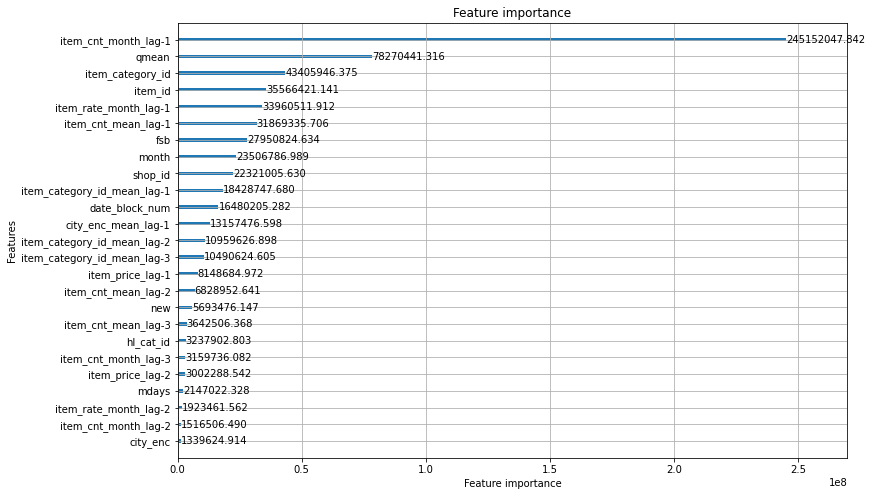

In [49]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [59]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 100)

d:\ncku\AI_env\.venv\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
d:\ncku\AI_env\.venv\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:1.07651	validation_1-rmse:0.97576
[1]	validation_0-rmse:0.98793	validation_1-rmse:0.90053
[2]	validation_0-rmse:0.93555	validation_1-rmse:0.86171
[3]	validation_0-rmse:0.90417	validation_1-rmse:0.83946
[4]	validation_0-rmse:0.88716	validation_1-rmse:0.82799
[5]	validation_0-rmse:0.87658	validation_1-rmse:0.82199
[6]	validation_0-rmse:0.86852	validation_1-rmse:0.81672
[7]	validation_0-rmse:0.86245	validation_1-rmse:0.81270
[8]	validation_0-rmse:0.85816	validation_1-rmse:0.81060
[9]	validation_0-rmse:0.85558	validation_1-rmse:0.80947
[10]	validation_0-rmse:0.85343	validation_1-rmse:0.80919
[11]	validation_0-rmse:0.85167	validation_1-rmse:0.80895
[12]	validation_0-rmse:0.84950	validation_1-rmse:0.80902
[13]	validation_0-rmse:0.84774	validation_1-rmse:0.80851
[14]	validation_0-rmse:0.84594	validation_1-rmse:0.80934
[15]	validation_0-rmse:0.84481	validation_1-rmse:0.80900
[16]	validation_0-rmse:0.84402	validation_1-rmse:0.80831
[17]	validation_0-rmse:0.84258	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=300,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

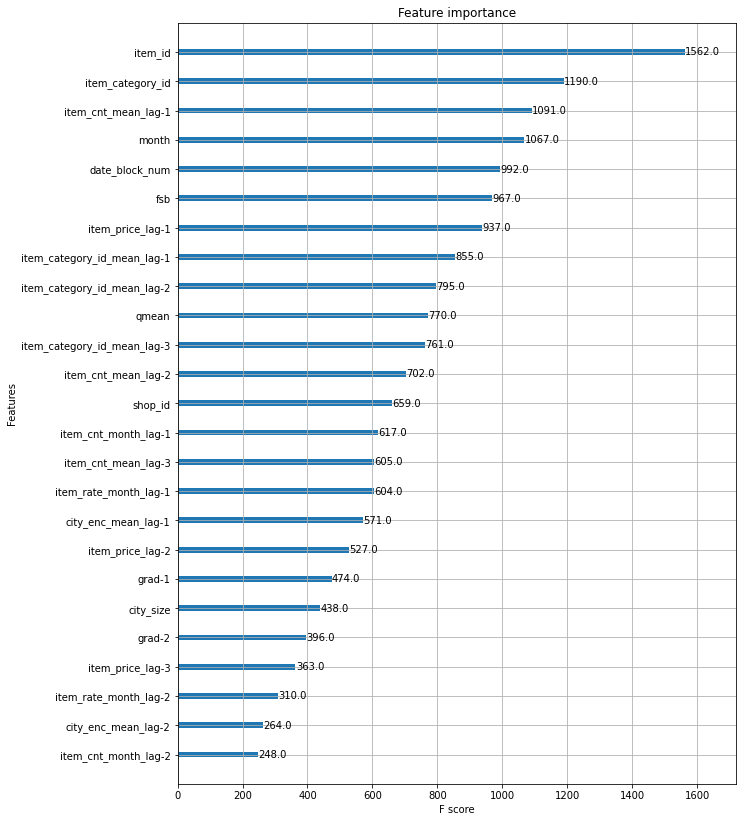

In [60]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": sample_submission.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission_xgb.csv', index=False)
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))